In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import pandas as pd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder
# Load the Adult dataset using fetch_openml
adult_data = fetch_openml(name='adult', version=2, as_frame=True)

# Extract features and target
# X = adult_data.data
# y = adult_data.target

def encode_categorical_data(X, y=None):
    # Create a copy of the dataframe to avoid modifying the original data
    X_encoded = X.copy()

    # Identify categorical columns
    categorical_cols = X_encoded.select_dtypes(include=['category', 'object']).columns

    # Apply LabelEncoder to each categorical column
    for col in categorical_cols:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col])

    # If target `y` is provided, encode it as well
    y_encoded = None
    if y is not None:
        le_target = LabelEncoder()
        y_encoded = le_target.fit_transform(y)

    return X_encoded, y_encoded

# Example usage:
# adult, cancer, diabetes, arrhythmia = load_datasets()

# Apply encoding to the features and target:
adult_X_encoded, adult_y_encoded = encode_categorical_data(adult_data.data, adult_data.target)







In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(adult_X_encoded)
y = adult_y_encoded
# Convert the data to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1).to(device)

In [ ]:
# Define a simple neural network for the victim model
class VictimModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(VictimModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Define the Generator network (for generating synthetic data)
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, z):
        return self.model(z)

In [ ]:
# splitting the data intio train and test set training victim or teacher model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [21]:
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Define the data-free distillation function with two generators
def data_free_distillation(generator_1, generator_0, victim, input_dim, Q, nG, lr, m, class_0_ratio=0.4):
    # Initialize optimizers for both generators
    optimizer_G1 = optim.Adam(generator_1.parameters(), lr=lr)
    optimizer_G0 = optim.Adam(generator_0.parameters(), lr=lr)

    # Initialize the Random Forest as the student model
    student = RandomForestClassifier(n_estimators=100)

    # Accumulate synthetic data for training the Random Forest
    X_synthetic = []
    Y_synthetic = []

    # Calculate the allocation for each class based on the ratio
    Q_class_0 = int(Q * class_0_ratio)  # Samples for class 0
    Q_class_1 = Q - Q_class_0  # Samples for class 1

    # Ensure both generators generate until their budget is exhausted
    while Q_class_1 > 0 or Q_class_0 > 0:
        # Train Generator for Class 1 if budget allows
        if Q_class_1 > 0:
            generator_1.train()
            victim.eval()

            for _ in range(nG):
                if Q_class_1 <= 0:
                    break
                # Generate synthetic data for class 1
                z1 = torch.randn((m, input_dim), requires_grad=True).to(device)  # Latent vector z for class 1
                x_generated_1 = generator_1(z1)

                # Query the victim model for class 1
                victim_output_1 = victim(x_generated_1)
                victim_output_1 = torch.sigmoid(victim_output_1)

                # Loss: Encourage generator to produce data classified as class 1 by the victim
                loss_G1 = -torch.mean(victim_output_1)
                optimizer_G1.zero_grad()
                loss_G1.backward()
                optimizer_G1.step()

                # Collect data for student training
                X_synthetic.append(x_generated_1.cpu().detach().numpy())
                Y_synthetic.append(victim_output_1.cpu().detach().numpy())

                # Decrement the class 1 query budget
                Q_class_1 -= m

        # Train Generator for Class 0 if budget allows
        if Q_class_0 > 0:
            generator_0.train()
            victim.eval()

            for _ in range(nG):
                if Q_class_0 <= 0:
                    break
                # Generate synthetic data for class 0
                z0 = torch.randn((m, input_dim), requires_grad=True).to(device)  # Latent vector z for class 0
                x_generated_0 = generator_0(z0)

                # Query the victim model for class 0
                victim_output_0 = victim(x_generated_0)
                victim_output_0 = torch.sigmoid(victim_output_0)

                # Loss: Encourage generator to produce data classified as class 0 by the victim
                loss_G0 = torch.mean(victim_output_0 - 1)  # Encourage lower outputs for class 0
                optimizer_G0.zero_grad()
                loss_G0.backward()
                optimizer_G0.step()

                # Collect data for student training
                X_synthetic.append(x_generated_0.cpu().detach().numpy())
                Y_synthetic.append(victim_output_0.cpu().detach().numpy())

                # Decrement the class 0 query budget
                Q_class_0 -= m

    # Flatten and convert lists to numpy arrays
    X_synthetic_np = np.vstack(X_synthetic)
    Y_synthetic_np = np.vstack(Y_synthetic)

    # Train the Random Forest student model
    student.fit(X_synthetic_np, (Y_synthetic_np > 0.5).astype(int).ravel())  # Assuming binary classification

    return student, X_synthetic_np, Y_synthetic_np

# Hyperparameters for distillation
Q = 10000  # Query budget
nG = 50  # Number of generator updates
lr = 0.0001  # Learning rate for generator
m = 32  # Batch size for generator

# Define input and output dimensions
input_dim = X_train.shape[1]  # Number of features
output_dim = 1  # Binary classification

# Instantiate models
victim_model = VictimModel(input_dim=input_dim, output_dim=output_dim).to(device)
generator_1 = Generator(input_dim=input_dim, output_dim=input_dim).to(device)  # Generator for class 1
generator_0 = Generator(input_dim=input_dim, output_dim=input_dim).to(device)  # Generator for class 0

# Training the victim model
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(victim_model.parameters(), lr=0.001)

for epoch in range(1000):
    victim_model.train()
    optimizer.zero_grad()
    outputs = victim_model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

print("Victim model training complete.")

# Run the data-free distillation process with two generators and RandomForest as the student
trained_student, X_synthetic, Y_synthetic = data_free_distillation(generator_1, generator_0, victim_model, input_dim, Q, nG, lr, m)

print("Student model (Random Forest) training complete.")


Victim model training complete.
Student model (Random Forest) training complete.


In [22]:
lst =pd.DataFrame(Y_synthetic).values.tolist()
sub_lst = []
for i in lst:
  if i[0]>0.5:
    i = 1
  else:
    i = 0
  sub_lst.append(i)

pd.DataFrame(sub_lst).value_counts()


,count
0,
0,6360
1,3656


In [23]:
from sklearn.metrics import accuracy_score

# Evaluate accuracy of the victim model
victim_model.eval()
with torch.no_grad():
    victim_outputs = victim_model(X_test)
    victim_predictions = (torch.sigmoid(victim_outputs) > 0.5).cpu().numpy()
victim_accuracy = accuracy_score(y_test.cpu().numpy(), victim_predictions)
print(f"Victim Model Accuracy: {victim_accuracy:.4f}")

# Evaluate accuracy of the student model (Random Forest)
student_predictions = trained_student.predict(X_test.cpu().numpy())
student_accuracy = accuracy_score(y_test.cpu().numpy(), student_predictions)
print(f"Student Model (Random Forest) Accuracy: {student_accuracy:.4f}")

# Evaluate fidelity of the student model
with torch.no_grad():
    victim_test_outputs = victim_model(X_test)
    victim_test_predictions = (torch.sigmoid(victim_test_outputs) > 0.5).cpu().numpy()

fidelity = accuracy_score(victim_test_predictions, student_predictions)
print(f"Student Model Fidelity: {fidelity:.4f}")


Victim Model Accuracy: 0.8368
Student Model (Random Forest) Accuracy: 0.7997
Student Model Fidelity: 0.8578


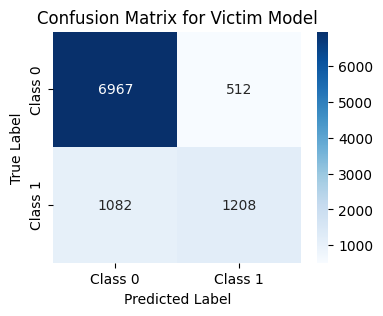

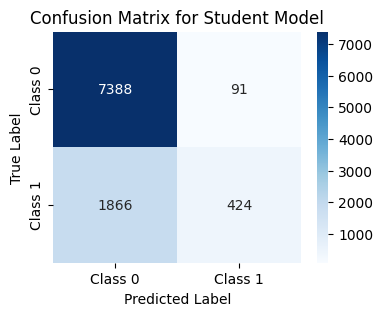

Confusion Matrix for Victim Model:
[[6967  512]
 [1082 1208]]

Confusion Matrix for Student Model:
[[7388   91]
 [1866  424]]


In [24]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Generate confusion matrices and return them along with the plot
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()
    return cm

# Get confusion matrices for victim and student models
cm_victim = plot_confusion_matrix(y_test.cpu().numpy(), victim_predictions, 'Confusion Matrix for Victim Model')
cm_student = plot_confusion_matrix(y_test.cpu().numpy(), student_predictions, 'Confusion Matrix for Student Model')

# Print confusion matrices
print("Confusion Matrix for Victim Model:")
print(cm_victim)

print("\nConfusion Matrix for Student Model:")
print(cm_student)


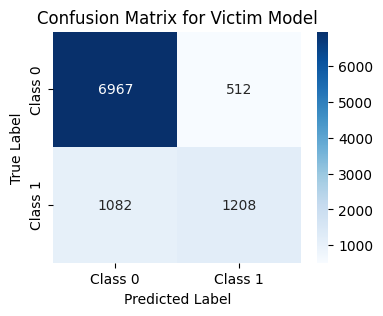

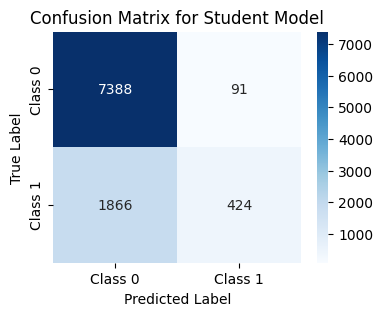

In [25]:
# import numpy as np
# import torch
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


# Generate confusion matrices
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# Plot confusion matrices for victim and student models
plot_confusion_matrix(y_test.cpu().numpy(), victim_predictions, 'Confusion Matrix for Victim Model')
plot_confusion_matrix(y_test.cpu().numpy(), student_predictions, 'Confusion Matrix for Student Model')


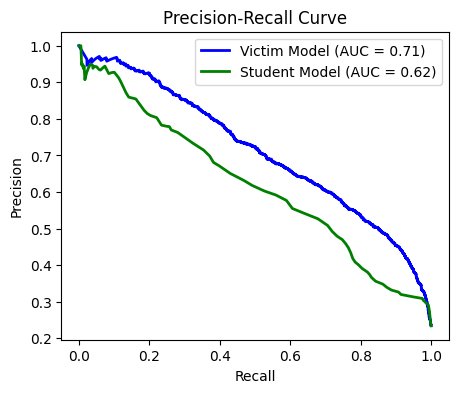

In [26]:


import numpy as np
import torch
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Calculate predicted probabilities for victim model
victim_model.eval()
with torch.no_grad():
    victim_outputs = victim_model(X_test)
    victim_probabilities = torch.sigmoid(victim_outputs).cpu().numpy()

# Calculate predicted probabilities for student model
student_probabilities = trained_student.predict_proba(X_test.cpu().numpy())[:, 1]

# Precision-Recall Curve for Victim Model
precision_victim, recall_victim, _ = precision_recall_curve(y_test.cpu().numpy(), victim_probabilities)
pr_auc_victim = auc(recall_victim, precision_victim)

# Precision-Recall Curve for Student Model
precision_student, recall_student, _ = precision_recall_curve(y_test.cpu().numpy(), student_probabilities)
pr_auc_student = auc(recall_student, precision_student)

# Plot Precision-Recall Curves
plt.figure(figsize=(5, 4))
plt.plot(recall_victim, precision_victim, color='blue', lw=2, label=f'Victim Model (AUC = {pr_auc_victim:.2f})')
plt.plot(recall_student, precision_student, color='green', lw=2, label=f'Student Model (AUC = {pr_auc_student:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

Victim Model Accuracy: 0.8368
Student Model (Random Forest) Accuracy: 0.7997
Student Model Fidelity: 0.8578


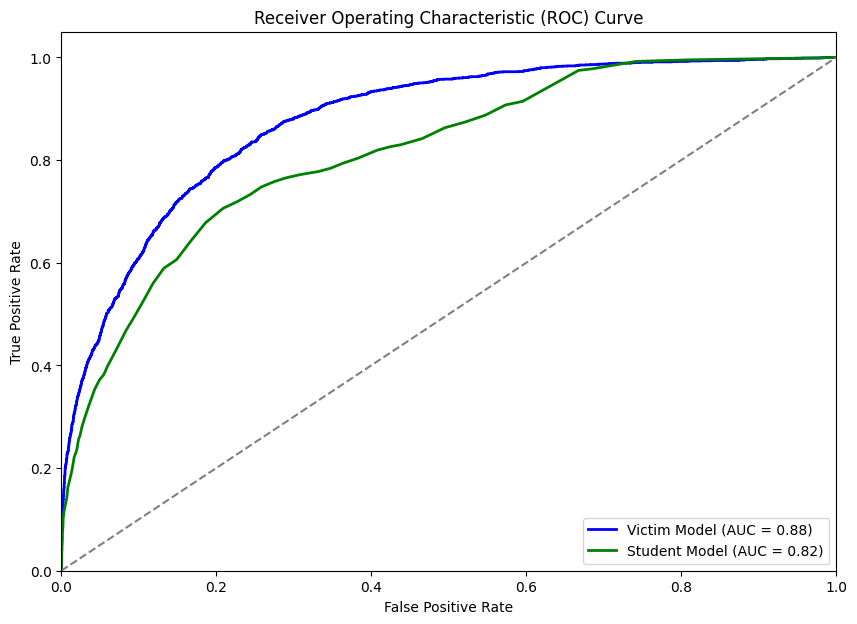

In [27]:
import numpy as np
import torch
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Evaluate accuracy of the victim model
victim_model.eval()
with torch.no_grad():
    victim_outputs = victim_model(X_test)
    victim_probabilities = torch.sigmoid(victim_outputs).cpu().numpy().flatten()

victim_accuracy = accuracy_score(y_test.cpu().numpy(), (victim_probabilities > 0.5).astype(int))
print(f"Victim Model Accuracy: {victim_accuracy:.4f}")

# Evaluate accuracy of the student model (Random Forest)
student_probabilities = trained_student.predict_proba(X_test.cpu().numpy())[:, 1]

student_predictions = (student_probabilities > 0.5).astype(int)
student_accuracy = accuracy_score(y_test.cpu().numpy(), student_predictions)
print(f"Student Model (Random Forest) Accuracy: {student_accuracy:.4f}")

# Evaluate fidelity of the student model
fidelity = accuracy_score((victim_probabilities > 0.5).astype(int), student_predictions)
print(f"Student Model Fidelity: {fidelity:.4f}")

# ROC Curve for Victim Model
fpr_victim, tpr_victim, _ = roc_curve(y_test.cpu().numpy(), victim_probabilities)
roc_auc_victim = auc(fpr_victim, tpr_victim)

# ROC Curve for Student Model
fpr_student, tpr_student, _ = roc_curve(y_test.cpu().numpy(), student_probabilities)
roc_auc_student = auc(fpr_student, tpr_student)

# Plot ROC Curves
plt.figure(figsize=(10, 7))
plt.plot(fpr_victim, tpr_victim, color='blue', lw=2, label=f'Victim Model (AUC = {roc_auc_victim:.2f})')
plt.plot(fpr_student, tpr_student, color='green', lw=2, label=f'Student Model (AUC = {roc_auc_student:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [28]:
import scipy.stats
import numpy as np
data = scipy.stats.norm.rvs(size=100000, loc=0, scale=1.5,
                            random_state=123)
hist = np.histogram(data, bins=100)